## [Nonlinear Causality Between High Tech and Semiconductor ETFs](https://medium.com/@kylejones_47003/what-drives-the-value-of-tech-stocks-d86ee4f7b370)

> Some ETFs just move together. XLK tracks big tech. SMH tracks chipmakers.

In [1]:
!pip install -q pandas numpy matplotlib pyinform yfinance tqdm

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import pyinform.transferentropy as te
import matplotlib.pyplot as plt
from tqdm import tqdm
import yfinance as yf

# Define tickers and time range
tickers = ['XLK', 'SMH']
data = yf.download(tickers, start="2015-01-01", end="2024-12-31")['Close'].dropna()
data.columns = ['Tech_ETF', 'Semiconductor_ETF']

# Save for analysis
data.to_csv("xlk_smh_prices.csv")

# Load and differenced data
df = pd.read_csv("xlk_smh_prices.csv", parse_dates=["Date"], index_col="Date")
df_diff = df.diff().dropna()

# Discretize to 3 bins (down, flat, up)
def discretize(series, bins=3):
    return pd.qcut(series.rank(method="first"), bins, labels=False)

# Rolling TE computation
window = 100
te_smh_to_xlk, te_xlk_to_smh, dates = [], [], []
for i in tqdm(range(window, len(df_diff))):
    sub = df_diff.iloc[i - window:i]
    xlk = discretize(sub["Tech_ETF"]).astype(int).values.reshape(1, -1)
    smh = discretize(sub["Semiconductor_ETF"]).astype(int).values.reshape(1, -1)
    try:
        te1 = te.transfer_entropy(smh, xlk, k=1)
        te2 = te.transfer_entropy(xlk, smh, k=1)
    except:
        te1, te2 = np.nan, np.nan
    te_smh_to_xlk.append(te1)
    te_xlk_to_smh.append(te2)
    dates.append(sub.index[-1])

# Store and smooth
te_df = pd.DataFrame({
    "SMH → XLK": te_smh_to_xlk,
    "XLK → SMH": te_xlk_to_smh
}, index=pd.to_datetime(dates))

te_df = te_df.rolling(window=10, min_periods=1).mean()

[*********************100%***********************]  2 of 2 completed
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2414/2414 [00:10<00:00, 222.75it/s]


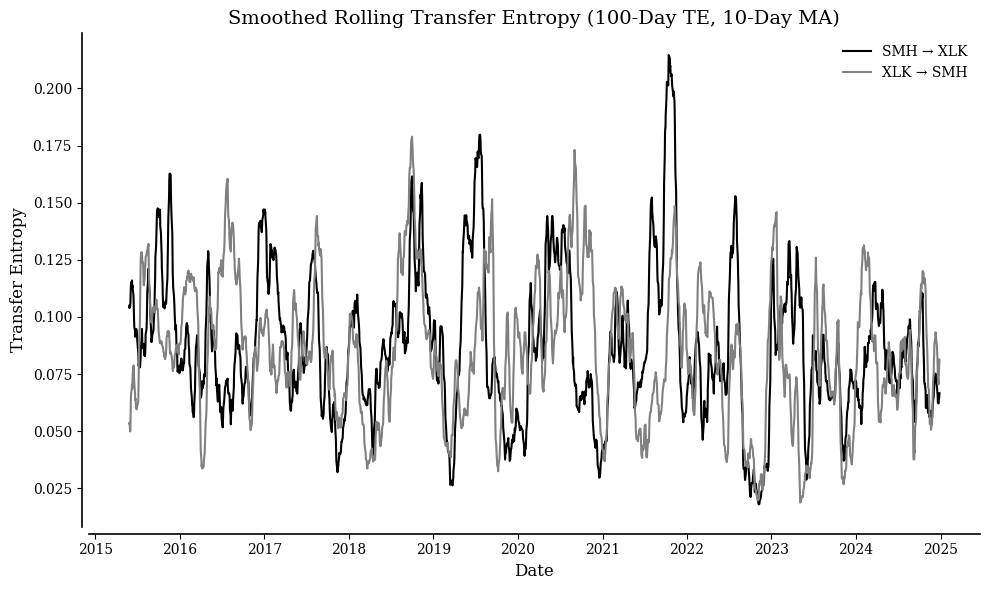

In [4]:
plt.rcParams.update({
    "font.family": "serif",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "xtick.direction": "out",
    "ytick.direction": "out",
})

def adjust_spines(ax):
    ax.spines["left"].set_position(("outward", 5))
    ax.spines["bottom"].set_position(("outward", 5))
    ax.spines["left"].set_linewidth(1.2)
    ax.spines["bottom"].set_linewidth(1.2)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(te_df.index, te_df["SMH → XLK"], label="SMH → XLK", color="black")
ax.plot(te_df.index, te_df["XLK → SMH"], label="XLK → SMH", color="gray")
adjust_spines(ax)
ax.set_title("Smoothed Rolling Transfer Entropy (100-Day TE, 10-Day MA)", fontsize=14)
ax.set_ylabel("Transfer Entropy", fontsize=12)
ax.set_xlabel("Date", fontsize=12)
ax.legend(frameon=False)
plt.tight_layout()
plt.savefig("rolling_transfer_entropy_smoothed.png")
plt.show()